In [1]:
from torchvision import utils
from basic_fcn import *

# if using transformed dataset, uncomment the following line and comment the line above
#from transform_fcn import *

# if using alternate architecture, uncomment the following line and comment the line above
#from alt_fcn import *

# if using transfer learning, uncomment the following line and comment the line above
#from transfer_fcn import * 

# if using U-Net, uncomment the following line and comment the line above
#from unet_fcn import *

from dataloader import *

# if using the transformed dataset for training, uncomment the following line and comment the line above
#from dataloader_transform import *

# if using transfer learning, uncomment the following lines and comment the line above
#from dataloader_transfer import *
#import dataloader as dlr

from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
import time
from matplotlib import pyplot as plt

## Initialize Dataset

In [2]:
batch_size = 4

# transformation applied to dataset
theTransform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(mode='CMYK'),
    torchvision.transforms.RandomCrop(512), 
    torchvision.transforms.RandomAffine((0,360), scale=(.8, 1.2)),
    torchvision.transforms.ToTensor()])


# if using our dataset transformation, include this additional argument (transforms=theTransform) to the line below
train_dataset = CityScapesDataset(csv_file='train.csv')
#train_dataset = CityScapesDataset(csv_file='train.csv', transforms=theTransform)
#batch_size = 30

val_dataset = CityScapesDataset(csv_file='val.csv')
test_dataset = CityScapesDataset(csv_file='test.csv')

# only uncomment the following for Transfer Learning
#theTransform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                 std=[0.229, 0.224, 0.225])
#train_dataset = CityScapesDataset(csv_file='train.csv', transforms = theTransform)
#val_dataset = CityScapesDataset(csv_file='val.csv', transforms = theTransform)
#test_dataset = CityScapesDataset(csv_file='test.csv', transforms = theTransform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          num_workers=4,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch_size,
                          num_workers=4,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          num_workers=4,
                          shuffle=True)

## Initialize Model

In [3]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
        
epochs     = 100
#criterion = # Choose an appropriate loss function from https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html

my_weights = torch.Tensor([0.4617, 0.4617, 0.4617, 0.4617, 0.4617, 0.4617, 0.4617, 0.4617, 0.7755, 0.4617, 0.4617, 0.5651, 
                  1, 0.9998, 0.4617, 0.4617, 0.4617, 0.9702, 0.4617, 0.9905, 0.9086, 0.4888, 0.9242, 0.4949,
                 0.8684, 0.99998, 0.6802, 1, 0.9991, 0.4617, 0.4617, 1, 1, 0.9861])


criterion = torch.nn.CrossEntropyLoss()
fcn_model = FCN(n_class=n_class)
#fcn_model = uNet(n_class=n_class) # Use this model for U-Net instead of FCN
fcn_model.apply(init_weights)
#fcn_model = torch.load('best_model')
optimizer = optim.Adam(fcn_model.parameters(), lr=5e-3)

## Define Train, Val, and Test Functions

In [4]:
use_gpu = torch.cuda.is_available()
cpu_device = torch.device("cpu")
if use_gpu:
    device = torch.device("cuda:0")
    #fcn_model = fcn_model.cuda()
    fcn_model = fcn_model.to(device)
    
# to account for class imbalance uncomment the lines below
#my_weights = my_weights.to(device)
#criterion = torch.nn.CrossEntropyLoss(weight=my_weights)
    
def train(batch_size, check_num = 5):
    # initialize lists for plotting per epoch stats
    counter = 0 
    losses = []
    accuracies = []
    IOUs = []
    val_losses = []
    val_accuracies = []
    val_IOUs = []
    class_val_IOUs = []
    for epoch in range(epochs):
        ts = time.time()
        # initialize loss and accuracy to be accumulated across the batches and later averaged
        rolling_loss = 0
        rolling_acc = 0
        for iter, (X, tar, Y) in enumerate(train_loader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = X.to(device)# Move your inputs onto the gpu
                labels = Y.to(device,dtype=torch.int64)# Move your labels onto the gpu
            else:
                inputs, labels = (X,Y)# Unpack variables into inputs and labels

            outputs = fcn_model(inputs) # forward pass data through model
            #outputs, labels = fcn_model(inputs,labels) # uncomment for U-Net
            prediction = F.softmax(outputs,dim = 1)
            prediction = torch.argmax(prediction,dim = 1) # convert outputs to class label predictions
            del inputs
            torch.cuda.empty_cache()
            loss = criterion(outputs, labels) # calculate loss
            Acc = pixel_acc(prediction, labels) # calculate accuracy
            del outputs, labels, prediction
            torch.cuda.empty_cache()
            rolling_acc += Acc 
            loss.backward() # backprop
            optimizer.step()
            
            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))
            
            rolling_loss += loss.item()
            del loss
            torch.cuda.empty_cache()
            
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        Normalizing_Factor = len(train_loader)# * batch_size
        losses.append(rolling_loss / Normalizing_Factor)
        accuracies.append(rolling_acc / Normalizing_Factor)
        #IOUs.append(rolling_iou)
        #print(losses)
        #print(accuracies)
        #print(IOUs)
        
        loss_val, acc_val, class_IOU_val, IOU_val = val(epoch, batch_size) # go through validation
        
        # append validation stats to corresponding lists
        val_losses.append(loss_val)
        val_accuracies.append(acc_val)
        val_IOUs.append(IOU_val)
        class_val_IOUs.append(class_IOU_val)
        fcn_model.train()
        #Early Stopping for validation IOUs
        if epoch == 0:
            torch.save(fcn_model.state_dict(), 'best_model.pt')
        else:
            if torch.argmax(torch.Tensor(val_accuracies)) == epoch:
                torch.save(fcn_model.state_dict(), 'best_model.pt')
                counter = 0
            else:
                counter += 1
        torch.save(val_losses,"val_losses")
        torch.save(val_accuracies,"val_accuracies")
        torch.save(val_IOUs,"val_IOUs")
        torch.save(class_val_IOUs, "class_val_IOUs")
        torch.save(losses,"train_loss")
        torch.save(accuracies,'train_accs')
        torch.save(IOUs,'train_IOU')
        if counter == check_num:
            print("early stop achieved")
            break


def val(epoch, batch_size):
    fcn_model.eval()
    ts = time.time()
    rolling_loss = 0
    rolling_acc = 0
    
    my_iou = iou_manager()
    
    for iter, (X, tar, Y) in enumerate(val_loader):
        if use_gpu:
            inputs = X.to(device)# Move your inputs onto the gpu
            labels = Y.to(device,dtype=torch.int64)# Move your labels onto the gpu
        else:
            inputs, labels = (X,Y)# Unpack variables into inputs and labels
        outputs = fcn_model(inputs)
        #outputs, labels = fcn_model(inputs,labels) # uncomment for U-Net
        prediction = F.softmax(outputs,dim = 1)
        prediction = torch.argmax(prediction,dim = 1) # convert outputs to class labels
        del inputs
        torch.cuda.empty_cache()
        loss = criterion(outputs,labels)
        del outputs
        rolling_loss += loss.item()
        #comp = outputs.data.to(cpu_device)
        #Acc, TP_sum, FP_sum, FN_sum = prediction_and_Accuracy(outputs, labels)
        Acc = pixel_acc(prediction, labels)
        ious = my_iou.iou(prediction, labels) # calculate IoU for the batch and keep a running TP, FP, FN
        #print(ious)
        del labels, prediction
        torch.cuda.empty_cache()
        rolling_acc += Acc
        
        if iter% 10 == 0:
            print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))
        del loss
        torch.cuda.empty_cache()
    
    # use accumulated accuracy stats to compute IoU for all val data
    class_TP = my_iou.rolling_TP
    class_FP = my_iou.rolling_FP
    class_FN = my_iou.rolling_FN
    class_IOU = []
    for k in range(len(class_TP)):
        intersection = class_TP[k]
        union = class_TP[k] + class_FP[k] + class_FN[k]
        if union == 0:
            class_IOU.append(float('nan'))  # if there is no ground truth, do not include in evaluation
        else:
            class_IOU.append(intersection/union) # iou for each batch
    
    # calculate average IoU
    IOU_avg = 0
    Unacceptable = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30]
    for k in range(34):
        if k in Unacceptable:
            continue
        IOU_avg += class_IOU[k]/19
    
    print("Finish val epoch {}, time elapsed {}".format(epoch, time.time() - ts))
    Normalizing_Factor = len(val_loader)# * batch_size
    rolling_acc /= Normalizing_Factor
    rolling_loss /= Normalizing_Factor
    print("Accuracy: ", rolling_acc)
    print("IOU: ", class_IOU)
    print("TP's: ", class_TP)
    print("FP's: ", class_FP)
    print("FN's: ", class_FN)
    
    return rolling_loss, rolling_acc, class_IOU, IOU_avg
    #Complete this function - Calculate loss, accuracy and IoU for every epoch
    # Make sure to include a softmax after the output from your model
    
def test(batch_size=1):
    '''
    fcn_model = FCN(n_class=n_class)
    use_gpu = torch.cuda.is_available()
    cpu_device = torch.device("cpu")
    if use_gpu:
        device = torch.device("cuda:0")
        #fcn_model = fcn_model.cuda()
        fcn_model = fcn_model.to(device)
    fcn_model.load_state_dict(torch.load(path))
    '''
    test_dataset = CityScapesDataset(csv_file='test.csv')
    
    # uncommnet the following only for Transfer Learning
    #test_dataset = CityScapesDataset(csv_file='test.csv', transforms = theTransform) # only TL
    test_loader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              num_workers=4,
                              shuffle=True)
    testImage, tar,label= test_dataset.__getitem__(0)
    testImage = testImage.unsqueeze(0)
    testImage = testImage.to(device)
    label = label.unsqueeze(0)
    label = label.to(device)
    
    #test_dataset = dlr.CityScapesDataset(csv_file='test.csv') # only TL
    #test_loader = DataLoader(dataset=test_dataset,            # only TL
    #                          batch_size=batch_size,          # only TL 
    #                          num_workers=4,                  # only TL
    #                          shuffle=True)                   # only TL
    #origImage, tar,label= test_dataset.__getitem__(0)         # only TL and U-Net
    #origImage = origImage.unsqueeze(0)                        # only U-Net
    #origImage = origImage.to(device)                          # only U-Net
    
    outputs = fcn_model(testImage)
    #outputs, labels = fcn_model(testImage,label) # uncomment for U-Net
    prediction = F.softmax(outputs,dim = 1)
    prediction = torch.argmax(prediction,dim = 1)
    prediction_numpy = np.squeeze(prediction.cpu().numpy())
    newMask=np.zeros((prediction_numpy.shape[0],prediction_numpy.shape[1],3))
    
    #origImage = center_crop(origImage, prediction) # only for U-Net
    
    for i in range(newMask.shape[0]):
        for j in range(newMask.shape[1]):
            label= prediction_numpy[i,j]
            RGBpixel=labels_classes[label].color
            newMask[i,j,:]= RGBpixel
    print(prediction_numpy.shape)
    #plt.imshow(prediction_numpy)
    #testImage = origImage # uncomment for U-Net
    testImage = np.squeeze(testImage.cpu().numpy())
    #testImage = origImage.numpy() # uncomment for Transfer Learning
    img = testImage / 2 + 0.5     # unnormalize
    original= 255*np.transpose(img, (1, 2, 0))
    
    scale=0.5
    overlay= scale*original+(1-scale)*newMask    
    plt.imshow((overlay).astype('uint8'))
    plt.suptitle("Base Function")

In [5]:
#val(0, batch_size) # show the accuracy before training
#train(batch_size) # train model if necessary
print("yay") # congratulations, the model finished training or you skipped it

yay


## Pass First Test Image Through Trained Model

In [6]:
# Path of desired model to pass into test.

path = "best_model_2_14_10_34.pt"
#path = "best_model_i.pt"
#path = "best_model_ii.pt"
#path = "best_model_iii.pt"
#path = "best_model_iv.pt"
#path = "best_model_v.pt"

(1024, 2048)


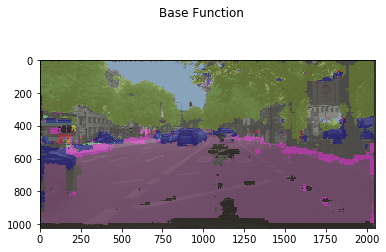

In [7]:
# Used to load pretrained model
fcn_model.load_state_dict(torch.load(path))
test() # test the model

## Pass Validation Set Through Trained Model

In [8]:
# Used to load pretrained model
fcn_model.load_state_dict(torch.load(path))
loss_val, acc_val, class_iou, iou = val(0,batch_size) # validation on pre-trained model

epoch0, iter0, loss: 0.7588772773742676
epoch0, iter10, loss: 1.228789210319519
epoch0, iter20, loss: 0.9651740789413452
epoch0, iter30, loss: 1.2425189018249512
epoch0, iter40, loss: 0.9549872279167175
epoch0, iter50, loss: 1.1448071002960205
epoch0, iter60, loss: 1.100188136100769
epoch0, iter70, loss: 0.9684842228889465
epoch0, iter80, loss: 0.6993926167488098
epoch0, iter90, loss: 0.912793755531311
epoch0, iter100, loss: 0.7731110453605652
epoch0, iter110, loss: 1.3635560274124146
epoch0, iter120, loss: 0.8389475345611572
Finish val epoch 0, time elapsed 97.69532418251038
Accuracy:  tensor(0.7376, device='cuda:0')
IOU:  [0.0, 0.5999319283352974, 0.6861667647712755, 0.995220482176687, 0.0004172263275161718, 0.0, 3.105113887011544e-06, 0.7727515611050292, 0.25425370622530763, 0.0008025808145374852, 0.0, 0.5708398790926665, 0.0, 0.00019196833704804243, 0.0, 0.0, nan, 0.030294094218324158, 0.0, 0.009471063556996707, 0.09585605778510263, 0.7158538310780869, 0.0787695505948446, 0.7034580

In [9]:
# Plotting class IoU's
temp = []
idx = []
Unacceptable = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30]
for k in range(34):
    if k in Unacceptable:
        continue
    temp.append(class_iou[k])
    idx.append(k)

Text(0, 0.5, 'Intersection-Over-Union')

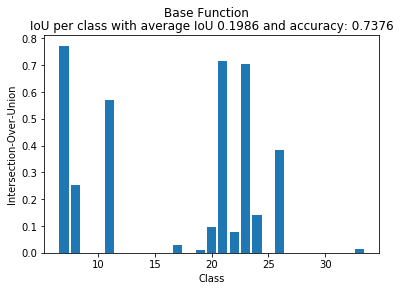

In [10]:
plt.bar(idx, temp)
plt.suptitle("Base Function")
plt.title("IoU per class with average IoU {:.4} and accuracy: {:.4}".format(iou, acc_val))
plt.xlabel("Class")
plt.ylabel("Intersection-Over-Union")

In [11]:
# Path of desired loss to plot

path1 = "train_loss_2_14_10_34"
#path1 = "train_loss_i"
#path1 = "train_loss_ii"
#path1 = "train_loss_iii"
#path1 = "train_loss_iv"
#path1 = "train_loss_v"

path2 = "val_losses_2_14_10_34"
#path2 = "val_losses_i"
#path2 = "val_losses_ii"
#path2 = "val_losses_iii"
#path2 = "val_losses_iv"
#path2 = "val_losses_v"

In [12]:
train_loss = torch.load(path1)
val_loss = torch.load(path2)

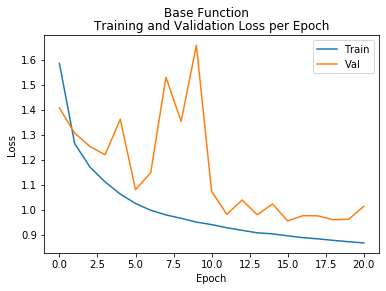

In [13]:
line1, = plt.plot(range(len(train_loss)), train_loss)
line2, = plt.plot(range(len(val_loss)), val_loss)
plt.suptitle("Base Function")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['Train', 'Val'])